In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

df = pd.read_csv('../data/model_train/정제데이터.csv', encoding = 'utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227044 entries, 0 to 227043
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence    227044 non-null  object
 1   Emotion     227044 non-null  int64 
 2   Processing  227044 non-null  object
 3   Length      227044 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.9+ MB


In [5]:
# 200,000개 데이터만 사용하도록 한다.
train_data = df[:150000]
test_data = df[150000:200000]
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

# train데이터 토크나이징
X_train = []
for i in train_data.Processing:
  train_tokenized = tokenizer(i, return_token_type_ids=False, return_attention_mask=False)['input_ids']
  X_train.append(train_tokenized)

토큰화 최대 길이 :  176
토큰화 평균 길이 :  50.32208


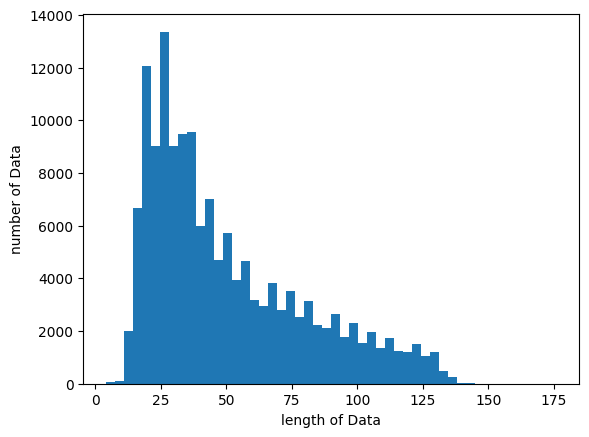

In [9]:
print("토큰화 최대 길이 : ", max(len(l) for l in X_train))
print("토큰화 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [10]:
X_test = []
for i in test_data.Processing:
  test_tokenized = tokenizer(i, return_token_type_ids=False, return_attention_mask=False)['input_ids']
  X_test.append(test_tokenized)

토큰화 최대 길이 :  178
토큰화 평균 길이 :  46.24148


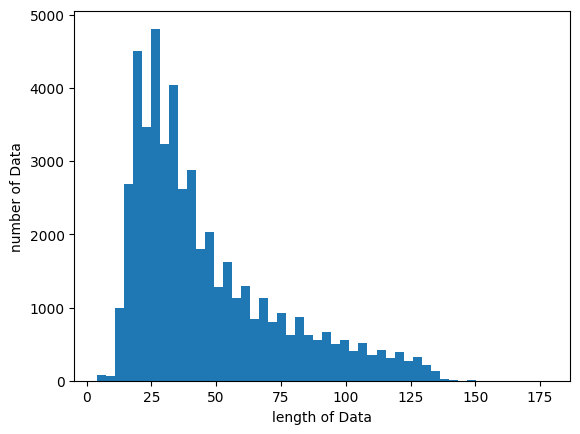

In [11]:
print("토큰화 최대 길이 : ", max(len(l) for l in X_test))
print("토큰화 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [12]:
# y 값 label (-1, 0, 1): one-hot encoding
y_train = []
y_test = []

for i in range(len(train_data['Emotion'])):
  if train_data['Emotion'].iloc[i] == 1:
    y_train.append([0, 0, 1])
  elif train_data['Emotion'].iloc[i] == 0:
    y_train.append([0, 1, 0])
  elif train_data['Emotion'].iloc[i] == -1:
    y_train.append([1, 0, 0])

for i in range(len(test_data['Emotion'])):
  if test_data['Emotion'].iloc[i] == 1:
    y_test.append([0, 0, 1])
  elif test_data['Emotion'].iloc[i] == 0:
    y_test.append([0, 1, 0])
  elif test_data['Emotion'].iloc[i] == -1:
    y_test.append([1, 0, 0])

y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

max_len = 176 # 전체 데이터의 길이를 176로 맞춘다 / 훈련셋 토큰화 최대 길이로

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
max_words = 70000

 # Sequential 모델 생성
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1,callbacks = [early_stopping])

Epoch 1/10
13500/13500 [==============================] - 1346s 99ms/step - loss: 0.2806 - accuracy: 0.8904 - val_loss: 0.2446 - val_accuracy: 0.9083
Epoch 2/10
13500/13500 [==============================] - 1311s 97ms/step - loss: 0.2151 - accuracy: 0.9204 - val_loss: 0.2395 - val_accuracy: 0.9091
Epoch 3/10
13500/13500 [==============================] - 1411s 104ms/step - loss: 0.1888 - accuracy: 0.9312 - val_loss: 0.2385 - val_accuracy: 0.9099
Epoch 4/10
13500/13500 [==============================] - 1471s 109ms/step - loss: 0.1675 - accuracy: 0.9399 - val_loss: 0.2544 - val_accuracy: 0.9039


In [16]:
print("\n 테스트 정확도 : {:.2f}%" .format(model.evaluate(X_test, y_test)[1]*100))

1563/1563 [==============================] - 40s 25ms/step - loss: 0.3529 - accuracy: 0.8590

 테스트 정확도 : 85.90%


In [17]:
# model 저장
from keras.models import load_model
model.save('../data/model_train/sa_model.h5')

c:\Users\Playdata\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
predict = model.predict(X_test)

1563/1563 [==============================] - 40s 25ms/step


In [19]:
predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)

In [20]:
# 0: 부정 / 1: 중립 / 2: 긍정
for i in range(30):
  print("Sentence : ", test_data['Sentence'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])

Sentence :  뚜껑 밀봉 불가능 해요. 굉장히 허술 ㅠㅠ /	 원래 라벨 :  0 /	예측한 라벨 :  0
Sentence :  마카롱 봉투로 샀어요 /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  가격치곤 좋움 잘샀음 /	 원래 라벨 :  0 /	예측한 라벨 :  2
Sentence :  재구매 계속 이것과 건조밀웜을 먹인 결과 진짜 배변냄새가 안나서 좋아요 /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  가격대비좋아욘ㆍㄷㅅㆍ /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  사이즈들이작아져서 이거쓰니편하네요 /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  USB는 잘되는데.. SD카드는 조립을 잘못했는지..카드자체가 안들어가네요.. /	 원래 라벨 :  0 /	예측한 라벨 :  0
Sentence :  꽃게다리가하나도없고...눈으로보앗을때는 ...그냥 사진첨부할게요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
Sentence :  너무좋습니다 또구매할거같네요 /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  엄마는 작다고 하셨는데 무난한크기같아요~ /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  좋네요 캠핑가서 잘쓸거같아요 /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  냄새가 너무 심하네요 못들고 다닐정도로요 반품하려다 그냥 냄새 빠지면 쓰려고요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
Sentence :  정말 가격만큼 얇은팔찌네요..컷팅이 이상한건지 원래그런건지는 모르겟지만 팔목이 쓸려서 엄청아프네요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
Sentence :  재구매 꼼꼼히잘받았습니다ㅋ /	 원래 라벨 :  2 /	예측한 라벨 :  2
Sentence :  편한데 ... 기대했던 맛은 아니에요. 좀 다른 버터 맛이네요. /	 원래 라벨 :  0 /	예측한 라벨 :